In [ ]:
# ===============================
# 1. Import Required Libraries
# ===============================
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from torch.utils.data import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
# ===============================
# 2. Load Dataset from Google Drive
# ===============================
drive.mount('/content/drive')

file_path = "/content/drive/MyDrive/Preprocessed_Data_CSE4114_.csv"
df = pd.read_csv(file_path)

# Selecting necessary columns
df = df[['tokenized_sentence_bert', 'hate']]
df.columns = ['input_ids', 'labels']

# Convert string representation to actual lists if needed
df['input_ids'] = df['input_ids'].apply(lambda x: eval(x) if isinstance(x, str) else x)

# ===============================
# 3. Stratified Train-Test Split
# ===============================
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# ===============================
# 4. Compute Class Weights (Handling Imbalance)
# ===============================
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df['labels']), y=train_df['labels'])
class_weights = torch.tensor(class_weights, dtype=torch.float).to("cuda" if torch.cuda.is_available() else "cpu")

print(f"Computed Class Weights: {class_weights}")

Mounted at /content/drive
Computed Class Weights: tensor([0.7500, 1.5000], device='cuda:0')


In [ ]:
# ===============================
# 5. Define Tokenizer & Model (mBERT Uncased)
# ===============================
model_name = "bert-base-multilingual-uncased"  # Using mBERT (Uncased)
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# ===============================
# 6. Define Custom Dataset Class
# ===============================
class BengaliDataset(Dataset):
    def __init__(self, tokenized_ids, labels):
        self.input_ids = tokenized_ids
        self.labels = labels

    def __getitem__(self, idx):
        item = {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long),
            'attention_mask': torch.tensor([int(token_id > 0) for token_id in self.input_ids[idx]], dtype=torch.long),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }
        return item

    def __len__(self):
        return len(self.labels)

# Prepare train and test datasets
train_dataset = BengaliDataset(train_df['input_ids'].tolist(), train_df['labels'].tolist())
test_dataset = BengaliDataset(test_df['input_ids'].tolist(), test_df['labels'].tolist())

# ===============================
# 7. Define Custom Weighted Trainer
# ===============================
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        # Apply weighted cross-entropy loss
        loss_fct = CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# ===============================
# 8. Define Training Arguments
# ===============================
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy='epoch',
    logging_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    weight_decay=0.01,
    report_to="none"
)

# Define function for accuracy computation
def compute_metrics(pred):
    logits, labels = pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    return {'accuracy': acc}

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
# ===============================
# 9. Train the Model with Class Weights
# ===============================
trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.411200,0.323057,0.870667
2,0.306100,0.357380,0.897833
3,0.253300,0.308788,0.895333
4,0.212400,0.367766,0.893500
5,0.175800,0.438485,0.893500


TrainOutput(global_step=7500, training_loss=0.2717539103190104, metrics={'train_runtime': 3163.919, 'train_samples_per_second': 37.928, 'train_steps_per_second': 2.37, 'total_flos': 7893331660800000.0, 'train_loss': 0.2717539103190104, 'epoch': 5.0})

Test Accuracy: 0.8978

Classification Report:
                  precision    recall  f1-score   support

Non-Hate Speech       0.92      0.93      0.92      4000
    Hate Speech       0.85      0.84      0.85      2000

       accuracy                           0.90      6000
      macro avg       0.89      0.88      0.88      6000
   weighted avg       0.90      0.90      0.90      6000



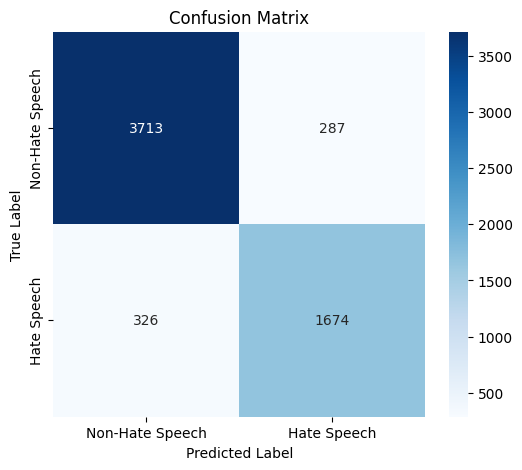

In [ ]:
# ===============================
# 10. Evaluate Model Performance
# ===============================
import torch
import numpy as np
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Define function to evaluate model
def evaluate_model(trainer, test_dataset):
    test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)
    trainer.model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in test_dataloader:
            input_ids = batch['input_ids'].to(trainer.model.device)
            attention_mask = batch['attention_mask'].to(trainer.model.device)
            labels = batch['labels'].cpu().numpy()

            outputs = trainer.model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1).cpu().numpy()

            all_preds.extend(preds)
            all_labels.extend(labels)

    return np.array(all_preds), np.array(all_labels)

# Evaluate model
y_pred, y_true = evaluate_model(trainer, test_dataset)

# Print accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification Report
report = classification_report(y_true, y_pred, target_names=['Non-Hate Speech', 'Hate Speech'])
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['Non-Hate Speech', 'Hate Speech'], yticklabels=['Non-Hate Speech', 'Hate Speech'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()